# Import

In [1]:
import sys
import os
sys.path.append("../src")

from utils import *
from mitigation_fct import *
from distance import *
from Gems_Wasserstein import *
from sampling import *

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
from scipy import stats
import ot

In [ ]:
result_path = '../Result/'
folders_name = os.listdir(result_path)
dic_arr_results = {}
for folder in folders_name:
    if (folder[-4:] != '.csv') and (folder[-5:] != '.json'):
        print(folder)
        files = os.listdir(result_path + folder)
        if files != []:
            dic_arr_results[folder] = {}
        for file in files:
            if file[-4:] == '.npy':
                try:
                    arr = np.load(file = result_path + folder + '/' + file)
                    dic_arr_results[folder][file[:-4]] = arr
                    print(f'successfuly loaded {file}')
                except:
                    print(f'error with the following : {file}')

ADULT
successfuly loaded DI.npy
successfuly loaded Grad_la_me.npy
successfuly loaded Grad_la_nu.npy
successfuly loaded Grad_reg_me.npy
successfuly loaded Grad_reg_nu.npy
successfuly loaded Miti_Gems_mean.npy
successfuly loaded Miti_Gems_number.npy
successfuly loaded Miti_grad.npy
successfuly loaded Miti_grad_look_alike.npy
successfuly loaded Miti_mod_SF.npy
successfuly loaded Miti_sampling_X.npy
successfuly loaded original.npy
successfuly loaded threshold.npy
ASC_EMP
successfuly loaded DI.npy
successfuly loaded Grad_la_me.npy
successfuly loaded Grad_la_nu.npy
successfuly loaded Grad_reg_me.npy
successfuly loaded Grad_reg_nu.npy
successfuly loaded Miti_Gems_mean.npy
successfuly loaded Miti_Gems_number.npy
successfuly loaded Miti_mod_SF.npy
successfuly loaded Miti_sampling_X.npy
successfuly loaded original.npy
successfuly loaded threshold.npy
successfuly loaded X_number_column.npy
ASC_INC
successfuly loaded DI.npy
successfuly loaded Grad_la_me.npy
successfuly loaded Grad_la_nu.npy
succes

In [11]:
def see_highest_DI_undetected(arr_original,
                              mitigation_fct,
                              KL_A_cdt,
                              W_A_cdt,
                              KL_P_cdt,
                              W_P_cdt,
                              number_simu = 50,
                              n_sample = 2000,
                              DI = 0.75
                              ):
    
    S_index, Y_index = -2, -1
    max_wass_iter = 1e7
    threshold_pvalue = 0.05
    DI_start = DI_fct(arr_original, 
                      S_index = S_index, 
                      Y_index = Y_index,
                      )
    while DI > DI_start:
        print(DI)
        arr_miti = mitigation_fct(DI = DI)

        S0_index_P = arr_original[:,S_index] == 0
        YS0_P, YS1_P = arr_original[S0_index_P, Y_index], arr_original[~S0_index_P, Y_index]

        for i in range(number_simu):
            sample = sample_arr(arr_miti, 
                                n_sample)
            
            DI_sample = DI_fct(sample, 
                               S_index = S_index, 
                               Y_index = Y_index)
            
            if DI_sample > DI:

                KL_P_sample = KL_arr(arr_P = arr_original[:,-2:],
                                     arr_Q = sample[:,-2:])
                
                if KL_P_sample < KL_P_cdt:

                    KL_A_sample = KL_arr(arr_P = arr_original,
                                         arr_Q = sample)
                    
                    if KL_A_sample < KL_A_cdt:

                        S0_index_sample = sample[:,S_index] == 0
                        YS0_s = sample[S0_index_sample, Y_index]
                        YS1_s = sample[~S0_index_sample, Y_index]
                        KS1_sample = stats.ks_2samp(YS1_P, YS1_s).pvalue
                        KS0_sample = stats.ks_2samp(YS0_P, YS0_s).pvalue

                        if min(KS0_sample, KS1_sample) > threshold_pvalue:

                            W_P_sample = Wasserstein(arr_original[:,-2:], 
                                                     sample[:,-2:],
                                                     numItermax = max_wass_iter)

                            if W_P_sample < W_P_cdt :

                                W_A_sample = Wasserstein(arr_original, 
                                                         sample,
                                                         numItermax = max_wass_iter)
                                
                                if W_A_sample < W_A_cdt:
                                    return DI_sample
        DI -= 0.05

In [ ]:
import json
dic_threshold_path = '../Result/dic_threshold.json'
with open(dic_threshold_path, 'r') as f:
    dic_threshold = json.load(f)

In [6]:
dic_sample_size_folder = {
    'ADULT'   : [500, 1000],
    'ASC_EMP' : [2000, 4000],
    'ASC_INC' : [2000, 4000],
    'ASC_MOB' : [2000, 4000],
    'ASC_PUC' : [2000, 4000],
    'ASC_TRA' : [2000, 4000],
    'BAF'     : [2000, 4000],
}

In [9]:
dic_highest_to_start = {
    'ADULT'   : 0.75,
    'ASC_EMP' : 0.75,
    'ASC_INC' : 0.95,
    'ASC_MOB' : 0.55,
    'ASC_PUC' : 0.75,
    'ASC_TRA' : 0.95,
    'BAF'     : 0.95,
}

In [14]:
dic_result = { 
    'ADULT': {
        500  : 0.524008470211183,
        1000 : 0.41673373274911324,
        },

    'ASC_EMP' : {
        2000: 0.3648034068995072,
        4000: 0.35703245854158083,

    },
    'ASC_INC' : {
        2000: 0.9558423483266908,
        4000: 0.8110873982586189,
    },
    'ASC_MOB' : {
        2000: 0.5410089737853757,
        
    }
    
}

for folder in dic_sample_size_folder.keys():
    if folder not in dic_result.keys():
        dic_result[folder] = {}
    for n_sample in dic_sample_size_folder[folder]:
        if n_sample not in dic_result[folder].keys():
            print(folder, n_sample)
            arr_original = dic_arr_results[folder]['original']
            mitigation_fct = lambda DI : find_sampling_wasserstein_DI(arr = arr_original,
                                                            threshold = DI,
                                                            S_index = -2,
                                                            Y_index = -1,
                                                            )[0]
            KL_A_cdt = dic_threshold[folder][str(n_sample)]['KL_A']
            W_A_cdt  = dic_threshold[folder][str(n_sample)]['W_A']
            KL_P_cdt = dic_threshold[folder][str(n_sample)]['KL_P']
            W_P_cdt  = dic_threshold[folder][str(n_sample)]['W_P']
            dic_result[folder][n_sample] =  see_highest_DI_undetected(arr_original   = arr_original,
                                                            mitigation_fct = mitigation_fct,
                                                            KL_A_cdt    = KL_A_cdt,
                                                            W_A_cdt     = W_A_cdt,
                                                            KL_P_cdt    = KL_P_cdt,
                                                            W_P_cdt     = W_P_cdt,
                                                            number_simu = 75,
                                                            n_sample = n_sample,
                                                            DI = dic_highest_to_start[folder],
                                                            )
            print(dic_result[folder][n_sample])


ASC_MOB 4000
0.55
0.5
0.45
0.46857063345740424
ASC_PUC 2000
0.75
0.7
0.6499999999999999
0.5999999999999999
0.5499999999999998
0.49999999999999983
0.44999999999999984
0.39999999999999986
0.34999999999999987
0.35395945192618017
ASC_PUC 4000
0.75
0.7
0.6499999999999999
0.5999999999999999
0.5499999999999998
0.49999999999999983
0.44999999999999984
0.39999999999999986
0.34999999999999987
None
ASC_TRA 2000
0.95
0.8999999999999999
0.8499999999999999
0.7999999999999998
0.8241046482092965
ASC_TRA 4000
0.95
0.8999999999999999
0.8499999999999999
0.7999999999999998
0.8014217701878767
BAF 2000
0.95
1.0313390313390314
BAF 4000
0.95
0.8999999999999999
0.8499999999999999
0.7999999999999998
0.7499999999999998
0.7948717948717949


ADULT 0.3 0.52
ASC_EMP 0.3 0.36
ASC_INC 0.67 0.96
ASC_MOB 0.45 0.54
ASC_PUC 0.32 0.35
ASC_TRA 0.69 0.82
BAF 0.35 1.03


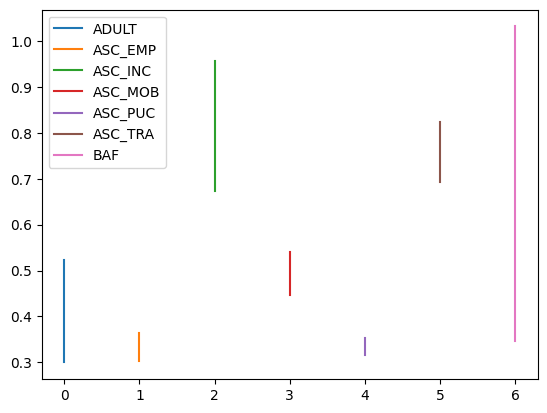

In [ ]:
folders_name = dic_sample_size_folder.keys()
for count, folder in enumerate(folders_name):
    DI_ini = np.load('../Result/' + folder + '/DI.npy')
    plt.plot([count, count], [DI_ini, dic_result[folder][dic_sample_size_folder[folder][0]]], label = folder)
    print(folder, DI_ini.round(2), np.round((dic_result[folder][dic_sample_size_folder[folder][0]]), 2))
plt.legend()
plt.show()

In [ ]:
dic_result[folder][]

{500: 0.524008470211183, 1000: 0.41673373274911324}

In [ ]:
with open('../Result/Highest_DI.npy', "w") as f:
    json.dump(dic_result, f) 

# Adult

In [ ]:
folder = 'ADULT' 
arr_original = dic_arr_results[folder]['original']
mitigation_fct = lambda DI : find_sampling_wasserstein_DI(arr = arr_original,
                                                          threshold = DI,
                                                          S_index = -2,
                                                          Y_index = -1,
                                                          )[0]
n_sample = 500
KL_A_cdt = dic_cdt[folder][n_sample]['KL_A_cdt']
W_A_cdt  = dic_cdt[folder][n_sample]['W_A_cdt']
KL_P_cdt = dic_cdt[folder][n_sample]['KL_P_cdt']
W_P_cdt  = dic_cdt[folder][n_sample]['W_P_cdt']

In [ ]:
see_highest_DI_undetected(arr_original   = arr_original,
                          mitigation_fct = mitigation_fct,
                          KL_A_cdt    = KL_A_cdt,
                          W_A_cdt     = W_A_cdt,
                          KL_P_cdt    = KL_P_cdt,
                          W_P_cdt     = W_P_cdt,
                          number_simu = 50,
                          n_sample = n_sample,
                          )

In [ ]:
n_sample = 1000
KL_A_cdt = dic_cdt[folder][n_sample]['KL_A_cdt']
W_A_cdt  = dic_cdt[folder][n_sample]['W_A_cdt']
KL_P_cdt = dic_cdt[folder][n_sample]['KL_P_cdt']
W_P_cdt  = dic_cdt[folder][n_sample]['W_P_cdt']

In [ ]:
see_highest_DI_undetected(arr_original   = arr_original,
                          mitigation_fct = mitigation_fct,
                          KL_A_cdt    = KL_A_cdt,
                          W_A_cdt     = W_A_cdt,
                          KL_P_cdt    = KL_P_cdt,
                          W_P_cdt     = W_P_cdt,
                          number_simu = 50,
                          n_sample = n_sample,
                          )

# Income

In [ ]:
folder = 'ASC_INC' 
arr_original = dic_arr_results[folder]['original']
mitigation_fct = lambda DI : find_sampling_wasserstein_DI(arr = arr_original,
                                                          threshold = DI,
                                                          S_index = -2,
                                                          Y_index = -1,
                                                          )[0]
n_sample = 2000
KL_A_cdt = dic_cdt[folder][n_sample]['KL_A_cdt']
W_A_cdt  = dic_cdt[folder][n_sample]['W_A_cdt']
KL_P_cdt = dic_cdt[folder][n_sample]['KL_P_cdt']
W_P_cdt  = dic_cdt[folder][n_sample]['W_P_cdt']

In [ ]:
see_highest_DI_undetected(arr_original   = arr_original,
                          mitigation_fct = mitigation_fct,
                          KL_A_cdt    = KL_A_cdt,
                          W_A_cdt     = W_A_cdt,
                          KL_P_cdt    = KL_P_cdt,
                          W_P_cdt     = W_P_cdt,
                          number_simu = 50,
                          n_sample = n_sample,
                          )

0.75
0
1
2
3
4
5


np.float64(0.7746742421665023)

In [16]:
n_sample = 4000
KL_A_cdt = dic_cdt[folder][n_sample]['KL_A_cdt']
W_A_cdt  = dic_cdt[folder][n_sample]['W_A_cdt']
KL_P_cdt = dic_cdt[folder][n_sample]['KL_P_cdt']
W_P_cdt  = dic_cdt[folder][n_sample]['W_P_cdt']

In [17]:
see_highest_DI_undetected(arr_original   = arr_original,
                          mitigation_fct = mitigation_fct,
                          KL_A_cdt    = KL_A_cdt,
                          W_A_cdt     = W_A_cdt,
                          KL_P_cdt    = KL_P_cdt,
                          W_P_cdt     = W_P_cdt,
                          number_simu = 50,
                          n_sample = n_sample,
                          )

0.75
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
0.7
0
1
2


np.float64(0.7003765595707545)

# EMP

In [33]:
folder = 'ASC_EMP' 
arr_original = dic_arr_results[folder]['original']
mitigation_fct = lambda DI : find_sampling_wasserstein_DI(arr = arr_original,
                                                          threshold = DI,
                                                          S_index = -2,
                                                          Y_index = -1,
                                                          )[0]
n_sample = 2000
KL_A_cdt = dic_cdt[folder][n_sample]['KL_A_cdt']
W_A_cdt  = dic_cdt[folder][n_sample]['W_A_cdt']
KL_P_cdt = dic_cdt[folder][n_sample]['KL_P_cdt']
W_P_cdt  = dic_cdt[folder][n_sample]['W_P_cdt']

In [34]:
see_highest_DI_undetected(arr_original   = arr_original,
                          mitigation_fct = mitigation_fct,
                          KL_A_cdt    = KL_A_cdt,
                          W_A_cdt     = W_A_cdt,
                          KL_P_cdt    = KL_P_cdt,
                          W_P_cdt     = W_P_cdt,
                          number_simu = 50,
                          n_sample = n_sample,
                          )

0.75


KeyboardInterrupt: 

# MOB

In [41]:
folder = 'ASC_MOB' 
arr_original = dic_arr_results[folder]['original']
mitigation_fct = lambda DI : find_sampling_wasserstein_DI(arr = arr_original,
                                                          threshold = DI,
                                                          S_index = -2,
                                                          Y_index = -1,
                                                          )[0]
n_sample = 2000
KL_A_cdt = dic_cdt[folder][n_sample]['KL_A_cdt']
W_A_cdt  = dic_cdt[folder][n_sample]['W_A_cdt']
KL_P_cdt = dic_cdt[folder][n_sample]['KL_P_cdt']
W_P_cdt  = dic_cdt[folder][n_sample]['W_P_cdt']

In [42]:
see_highest_DI_undetected(arr_original   = arr_original,
                          mitigation_fct = mitigation_fct,
                          KL_A_cdt    = KL_A_cdt,
                          W_A_cdt     = W_A_cdt,
                          KL_P_cdt    = KL_P_cdt,
                          W_P_cdt     = W_P_cdt,
                          number_simu = 50,
                          n_sample = n_sample,
                          DI = dic_highest_to_start[folder],
                          )

0.75
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
0.7
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
0.6499999999999999
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
0.5999999999999999
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
0.5499999999999998
0
1
2
3
4
5
6
7
8
9
10
11


np.float64(0.5659699062821484)

In [43]:
n_sample = 4000
KL_A_cdt = dic_cdt[folder][n_sample]['KL_A_cdt']
W_A_cdt  = dic_cdt[folder][n_sample]['W_A_cdt']
KL_P_cdt = dic_cdt[folder][n_sample]['KL_P_cdt']
W_P_cdt  = dic_cdt[folder][n_sample]['W_P_cdt']

In [44]:
see_highest_DI_undetected(arr_original   = arr_original,
                          mitigation_fct = mitigation_fct,
                          KL_A_cdt    = KL_A_cdt,
                          W_A_cdt     = W_A_cdt,
                          KL_P_cdt    = KL_P_cdt,
                          W_P_cdt     = W_P_cdt,
                          number_simu = 50,
                          n_sample = n_sample,
                          DI = dic_highest_to_start[folder],
                          )

0.75
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
0.7
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
0.6499999999999999
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
0.5999999999999999
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
0.5499999999999998
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
0.49999999999999983
0
1
2
3
4


np.float64(0.5034765762642711)

# BAF

In [35]:
folder = 'BAF' 
arr_original = dic_arr_results[folder]['original']
mitigation_fct = lambda DI : find_sampling_wasserstein_DI(arr = arr_original,
                                                          threshold = DI,
                                                          S_index = -2,
                                                          Y_index = -1,
                                                          )[0]
n_sample = 2000
KL_A_cdt = dic_cdt[folder][n_sample]['KL_A_cdt']
W_A_cdt  = dic_cdt[folder][n_sample]['W_A_cdt']
KL_P_cdt = dic_cdt[folder][n_sample]['KL_P_cdt']
W_P_cdt  = dic_cdt[folder][n_sample]['W_P_cdt']

In [37]:
see_highest_DI_undetected(arr_original   = arr_original,
                          mitigation_fct = mitigation_fct,
                          KL_A_cdt    = KL_A_cdt,
                          W_A_cdt     = W_A_cdt,
                          KL_P_cdt    = KL_P_cdt,
                          W_P_cdt     = W_P_cdt,
                          number_simu = 50,
                          n_sample = n_sample,
                          DI = dic_highest_to_start[folder],
                          )

0.95
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
0.8999999999999999
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
0.8499999999999999
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
0.7999999999999998
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
0.7499999999999998
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
0.6999999999999997
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
0.6499999999999997
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


In [38]:
n_sample = 4000
KL_A_cdt = dic_cdt[folder][n_sample]['KL_A_cdt']
W_A_cdt  = dic_cdt[folder][n_sample]['W_A_cdt']
KL_P_cdt = dic_cdt[folder][n_sample]['KL_P_cdt']
W_P_cdt  = dic_cdt[folder][n_sample]['W_P_cdt']

In [39]:
see_highest_DI_undetected(arr_original   = arr_original,
                          mitigation_fct = mitigation_fct,
                          KL_A_cdt    = KL_A_cdt,
                          W_A_cdt     = W_A_cdt,
                          KL_P_cdt    = KL_P_cdt,
                          W_P_cdt     = W_P_cdt,
                          number_simu = 50,
                          n_sample = n_sample,
                          DI = dic_highest_to_start[folder],
                          )

0.95
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
0.8999999999999999
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
0.8499999999999999
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
0.7999999999999998
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
0.7499999999999998
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
0.6999999999999997
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
0.6499999999999997
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


# Graph

In [ ]:
list_dataset = ['ADULT', 'ADULT', 
                'ASC_EMP', 'ASC_EMP',
                'ASC_INC', 'ASC_INC', 
                'ASC_MOB', 'ASC_MOB', 
                'ASC_PUC', 'ASC_PUC', 
                'ASC_TRA', 'ASC_TRA',
                'BAF', 'BAF']
list_

In [ ]:
dic_result = {
    'ADULT' : ['/5', 0.40, 0.65]   : /10 : 0.65 ;  : 0.55
'ASC_EMP' : /10 : 0.40 ; /5 : 0.35
'ASC_INC' : /10 : 0.75 ; /5 : 0.70
'ASC_MOB' : /10 : 0.55 ; /5 : 0.50
'ASC_PUC' : /10 : 0.25 ; /5 : 0.25
'ASC_TRA' : /10 : 1    ; /5 0.85
'BAF'     : /10 : 

In [ ]:
df = pd.DataFrame